# Prueba Havas Media Group

## Punto 1. Conexión con API, transformación y visualización en Power BI

In [ ]:
import requests 
import pandas as pd
import datetime 
import time
import warnings
warnings.filterwarnings("ignore")

#creción del dataframe que tendrá la ingesta de los datos de la api
df = pd.DataFrame(columns=['ciudad', 'temp', 'sensacion', 'humedad', 'wind', 'sky', 'sunrise', 'sunset', 'date'])

ciudades = [
    'Bogotá', 'Leticia', 'Medellín', 'Arauca', 'Barranquilla', 'Cartagena',
    'Tunja', 'Manizales', 'Yopal', 'Popayán', 'Valledupar', 'Quibdó',
    'Montería', 'Inírida', 'San José del Guaviare', 'Neiva', 'Riohacha', 'Santa Marta',
    'Villavicencio', 'Pasto', 'Cúcuta', 'Mocoa', 'Pereira',
    'San Andrés', 'Bucaramanga', 'Sincelejo', 'Ibagué', 'Mitú', 'Puerto Carreño'
] #ciudades seleccionadas

#establecer la conexión e iterar la información por cada ciudad
for ciudad in ciudades:
    url = f"https://api.openweathermap.org/data/2.5/weather?q={ciudad},col&APPID=cb03506a247d34d9b2ecce775b098155&units=metric"
    response = requests.get(url).json()
    
    time.sleep(1) #una pausa para que consuma enteramente los datos
    
    #seleccionar el tipo de dato que necesitamos 
    ciudad = response['name']
    temp = response['main']['temp']
    sensacion = response['main']['feels_like']
    humedad = response['main']['humidity']
    sky =  response['weather'][0]['description']
    wind = response['wind']['speed']
    sunrise = datetime.datetime.fromtimestamp(response['sys']['sunrise'])
    sunrise = str(sunrise).split(' ')[1]
    sunset = datetime.datetime.fromtimestamp(response['sys']['sunset'])
    sunset = str(sunset).split(' ')[1]
    date = datetime.datetime.fromtimestamp(response['dt'])
    date = str(date).split(' ')[0]
    
    #el dataframe se alimenta
    df = df.append({'ciudad':ciudad, 'temp':temp, 'sensacion':sensacion , 'humedad':humedad, 'wind':wind,'sky':sky, 'sunrise':sunrise, 'sunset': sunset, 'date':date}, ignore_index = True)
df

In [ ]:
#guardado de df para uso en Power BI
df.to_excel('api_clima.xlsx')

In [ ]:
### Visualización del Dashboard vía Power BI
#### Se solicitará autenticación en la plataforma

In [ ]:
from powerbiclient import Report, models
from powerbiclient.authentication import DeviceCodeLoginAuthentication
#conexiones

device_auth = DeviceCodeLoginAuthentication()
access_token = device_auth.get_access_token()
group_id = '3509066b-6371-4341-b594-7fba18857caa'
report_id = '7b260c0e-96c0-4366-a506-7bf5e960f9cd'
report = Report(group_id=group_id, report_id = report_id, auth=device_auth)
report

## Punto 2. Pensamiento lógico

In [6]:
#crear el diccionario que contendrá una secuencia hasta 5000 de 100 en 100 en sus llaves y los primeros numeros naturales del 1 al 9 en sus valores, repitiendose en
#cada ciclo de 9
dicc = {}

for i in range(0, 5001, 100):
    valor = (i // 100) % 9 + 1
    dicc[i] = valor

In [14]:
n = []
llaves_list = list(dicc.keys())
values_list = list(dicc.values())
y = 0
x = values_list

for i in range(0,50): #rango suficiente para obtener los 5000 digitos.
    if i <= llaves_list[y]:
        lista = list(range(llaves_list[y], llaves_list[y+1], values_list[y])) #crea un ciclo de 0 a 99 (y sucesivamente) en el que se intercalan las sumas de 1 en 1, 2 en 2...
        n.append(lista) #dara como resultado multiples listas cada 100 digitos
        y += 1
    else:
        print('error')

resultado = []
for lista in n:
    resultado.extend(lista) #integro las multiples listas en una secuencia de una sola lista

In [15]:
#exporta el listado de digitos
serie = pd.Series(resultado)
df = pd.DataFrame(serie)
df.to_excel('serie.xlsx', index = False)

## Punto 3. Modelo conceptual entre API y DANE.

In [17]:
#carga datos Dane
!pip install xlrd
df_dane = pd.read_excel('dane.xls', sheet_name = '200,000ymas', header = 9)
df_dane = df_dane.iloc[0:31]
df_dane = df_dane.drop('QUINCENA', axis = 1)
df_dane['NOMBRE MUNICIPIO'] = df_dane['NOMBRE MUNICIPIO'].replace('San José de Cúcuta', 'Cúcuta')
df_dane.head()

Defaulting to user installation because normal site-packages is not writeable


##### La granularidad de los datos si bien también es a nivel de ciudad, difiere en variados casos con los nombres que la API nos provee. 
##### Podriamos entonces configurar una función con reglas que permitan identificar las palabras similares en el df API y df DANE e indexar con el mismo número.
##### Como los datos son pocos, se podría asignar también manualmente o cambiar las ciudades en el df Dane para que coincidan plenamente.
##### Con una identificación de ciudad establecida, creamos dos tablas dimensionales a partir del df Dane: 1. Ciudades y 2.Departamentos.
##### Nuestra tabla de hechos será entonces el df API que en el caso de tener actualizaciones diarias, horas etc...repetiria el id de la ciudad.

In [ ]:
## Se crea entonces el modelo fisico, en este caso usando MySql Workbench, que estaría alimentadose de la información proveniente de Python.
### El esquema llamado havas_media y 3 tablas: clima, ciudades y departamento.

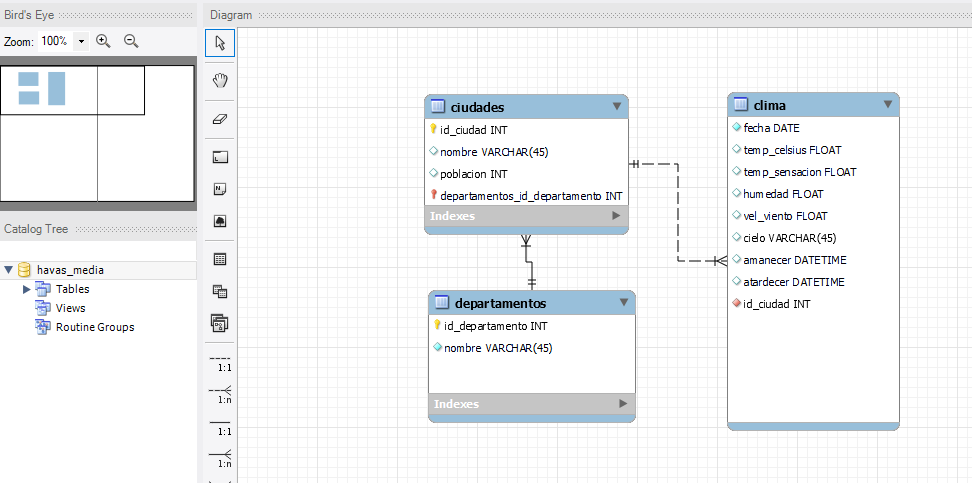